In [1]:
!pip install numpy faiss-cpu sentence-transformers datasets scikit-learn scipy matplotlib pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [55]:
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial import distance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize

In [56]:
def load_and_encode_data(dataset_name="go_emotions", split="train", sample_size=1000, model_name="all-MiniLM-L6-v2"):
    dataset = load_dataset(dataset_name, split=split)
    dataset = dataset.shuffle(seed=42).select(range(sample_size))
    texts = dataset['text']
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts)
    embeddings = normalize(embeddings)
    return embeddings, texts

In [57]:
def create_faiss_index(embeddings, metric="l2"):
    dimension = embeddings.shape[1]
    if metric == "l2":
        index = faiss.IndexIDMap(faiss.IndexFlatL2(dimension)) # L2 distance (Euclidean)
    elif metric == "ip":
        index = faiss.IndexIDMap(faiss.IndexFlatIP(dimension)) # Inner Product (Cosine similarity)
    else:
        raise ValueError("Invalid Metrics. 'l2' hoặc 'ip'.")
    index.add_with_ids(embeddings, np.arange(embeddings.shape[0]))
    return index

In [44]:
def cosine_distance(query_embedding, embeddings, **kwargs):
    return cosine_distances(query_embedding.reshape(1, -1), embeddings)[0]

def correlation_distance(query_embedding, embeddings, **kwargs):
  return np.array([distance.correlation(query_embedding, emb) for emb in embeddings])

def euclidean_distance(query_embedding, embeddings, **kwargs):
    return np.linalg.norm(embeddings - query_embedding, axis=1)

def mahalanobis_distance(query_embedding, embeddings, VI=None, **kwargs):
    if VI is None:
        raise ValueError("VI required")
    delta = embeddings - query_embedding
    return np.sqrt(np.sum(np.dot(delta, VI) * delta, axis=1))


In [45]:
def semantic_search(query, index, embeddings, texts, distance_function, top_k=5, model_name="all-MiniLM-L6-v2", **kwargs):
    model = SentenceTransformer(model_name)
    query_embedding = model.encode(query)
    distances = distance_function(query_embedding, embeddings, **kwargs)
    indices = np.argsort(distances)[:top_k]
    results = [(texts[i], distances[i]) for i in indices]
    return results


In [46]:
def calculate_precision_recall(results, ground_truth_indices, k=5):
    retrieved_indices = [texts.index(result[0]) for result in results[:k]]
    relevant_retrieved = set(retrieved_indices).intersection(set(ground_truth_indices))
    precision = len(relevant_retrieved) / k if k > 0 else 0.0
    recall = len(relevant_retrieved) / len(ground_truth_indices) if len(ground_truth_indices) > 0 else 0.0
    return precision, recall

In [47]:
def visualize_embeddings(embeddings, labels, metric_name="default", perplexity=30, n_iter=300):
    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, n_iter=n_iter)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title(f't-SNE Visualization of Embeddings (Metric: {metric_name})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

In [49]:
def plot_precision_recall(results_df):
    results_df_melted = results_df.melt(id_vars=['query', 'metric'], var_name='evaluation_metric', value_name='value')

    g = sns.FacetGrid(results_df_melted, col="evaluation_metric", height=5, aspect=1.2)
    g.map(sns.barplot, "query", "value", "metric", palette="muted", order=queries, dodge=True)
    g.set_xticklabels(rotation=45, ha="right")
    g.set_axis_labels("", "Value")
    g.set_titles("Evaluate: {col_name}")
    g.add_legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle("Comparing Precision@5 và Recall@5")
    plt.show()

In [66]:

# 1. Download, encode
embeddings, texts = load_and_encode_data(sample_size=500)

# 2. FAISS index (cosine similarity)
index = create_faiss_index(embeddings, metric="ip")

# 3. Calculate the inverse covariance matrix ( Mahalanobis)
covariance_matrix = np.cov(embeddings, rowvar=False)
VI = np.linalg.inv(covariance_matrix)

# 4. ground truth query
queries = [
    "I am feeling very happy today",
    "This is a sad situation",
    "I am so angry right now",
    "I am really excited about the future",
    "I feel nothing"
]

# ground_truth = {
#     queries[0]: [i for i, text in enumerate(texts) if "happy" in text.lower() or "joyful" in text.lower()],
#     queries[1]: [i for i, text in enumerate(texts) if "sad" in text.lower() or "unhappy" in text.lower() or "depressed" in text.lower()],
#     queries[2]: [i for i, text in enumerate(texts) if "angry" in text.lower() or "mad" in text.lower() or "furious" in text.lower()],
#     queries[3]: [i for i, text in enumerate(texts) if "excited" in text.lower() or "thrilled" in text.lower() or "eager" in text.lower() or "future" in text.lower() or "plan" in text.lower() or "goal" in text.lower()],
#     queries[4]: [i for i, text in enumerate(texts) if "nothing" in text.lower() or "empty" in text.lower() or "numb" in text.lower()]
# }
import re
ground_truth = {
    queries[0]: [i for i, text in enumerate(texts) if re.search(r"\b(happy|joyful|cheerful|delighted|glad)\b", text.lower())],
    queries[1]: [i for i, text in enumerate(texts) if re.search(r"\b(sad|unhappy|depressed| sorrowful|miserable)\b", text.lower())],
    queries[2]: [i for i, text in enumerate(texts) if re.search(r"\b(angry|mad|furious|irate|annoyed)\b", text.lower())],
    queries[3]: [i for i, text in enumerate(texts) if re.search(r"\b(excited|thrilled|eager|anticipating|looking forward to)\b", text.lower())],
    queries[4]: [i for i, text in enumerate(texts) if re.search(r"\b(nothing|empty|numb|void|apathetic)\b", text.lower())]
}
# enhance: use wordnet
# import nltk
# from nltk.corpus import wordnet as wn
# try:
#     nltk.data.find('corpora/wordnet')
# except LookupError:
#     nltk.download('wordnet')
# ground_truth = {}
# for query in queries:
#     keywords = query.lower().split()
#     all_synonyms = set()
#     for keyword in keywords:
#       for syn in wn.synsets(keyword):
#         for lemma in syn.lemmas():
#             all_synonyms.add(lemma.name())
#     ground_truth[query] = [i for i, text in enumerate(texts) if any(synonym in text.lower() for synonym in all_synonyms)]


Query: I am feeling very happy today
Cosine Distance - Precision@5: 1.000, Recall@5: 0.011
Top 5 documents:
- Bee happy! ' v') (Distance: 0.5862)
- Hope you're still doing ok ❤✌ (Distance: 0.5968)
- Sorry, "semi". Happy? (Distance: 0.6254)
- This is how it should be. I'm so happy to see this post. (Distance: 0.6366)
- Its like you are flexing that you have gf ,when most of people here doesnt have that feeling (Distance: 0.6481)
Euclidean Distance - Precision@5: 1.000, Recall@5: 0.011
Top 5 documents:
- Bee happy! ' v') (Distance: 1.0828)
- Hope you're still doing ok ❤✌ (Distance: 1.0926)
- Sorry, "semi". Happy? (Distance: 1.1184)
- This is how it should be. I'm so happy to see this post. (Distance: 1.1283)
- Its like you are flexing that you have gf ,when most of people here doesnt have that feeling (Distance: 1.1385)
Correlation Distance - Precision@5: 1.000, Recall@5: 0.011
Top 5 documents:
- Bee happy! ' v') (Distance: 0.5863)
- Hope you're still doing ok ❤✌ (Distance: 0.5969)
- So

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


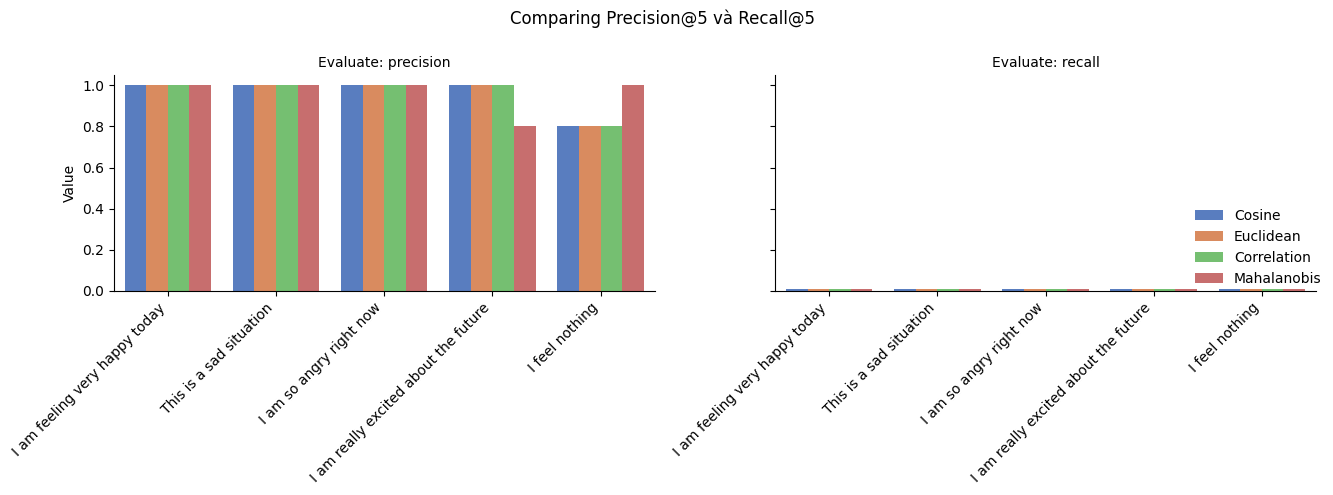

In [65]:
results_data = []
for query in queries:
    print(f"\nQuery: {query}")

    # Find top N with Cosine Distance
    results_cosine = semantic_search(query, index, embeddings, texts, cosine_distance)
    precision_cosine, recall_cosine = calculate_precision_recall(results_cosine, ground_truth[query])
    print(f"Cosine Distance - Precision@5: {precision_cosine:.3f}, Recall@5: {recall_cosine:.3f}")
    print("Top 5 documents:")
    for doc, dist in results_cosine:
        print(f"- {doc} (Distance: {dist:.4f})")
    results_data.append({'query': query, 'metric': 'Cosine', 'precision': precision_cosine, 'recall': recall_cosine})

    # Find top N with Euclidean Distance
    results_euclidean = semantic_search(query, index, embeddings, texts, euclidean_distance)
    precision_euclidean, recall_euclidean = calculate_precision_recall(results_euclidean, ground_truth[query])
    print(f"Euclidean Distance - Precision@5: {precision_euclidean:.3f}, Recall@5: {recall_euclidean:.3f}")
    print("Top 5 documents:")
    for doc, dist in results_euclidean:
        print(f"- {doc} (Distance: {dist:.4f})")
    results_data.append({'query': query, 'metric': 'Euclidean', 'precision': precision_euclidean, 'recall': recall_euclidean})

    #Find top N with Correlation Distance
    results_correlation = semantic_search(query, index, embeddings, texts, correlation_distance)
    precision_correlation, recall_correlation = calculate_precision_recall(results_correlation, ground_truth[query])
    print(f"Correlation Distance - Precision@5: {precision_correlation:.3f}, Recall@5: {recall_correlation:.3f}")
    print("Top 5 documents:")
    for doc, dist in results_correlation:
        print(f"- {doc} (Distance: {dist:.4f})")
    results_data.append({'query': query, 'metric': 'Correlation', 'precision': precision_correlation, 'recall': recall_correlation})

    #Find top N with Mahalanobis Distance
    results_mahalanobis = semantic_search(query, index, embeddings, texts, mahalanobis_distance, VI=VI)
    precision_mahalanobis, recall_mahalanobis = calculate_precision_recall(results_mahalanobis, ground_truth[query])
    print(f"Mahalanobis Distance - Precision@5: {precision_mahalanobis:.3f}, Recall@5: {recall_mahalanobis:.3f}")
    print("Top 5 documents:")
    for doc, dist in results_mahalanobis:
        print(f"- {doc} (Distance: {dist:.4f})")
    results_data.append({'query': query, 'metric': 'Mahalanobis', 'precision': precision_mahalanobis, 'recall': recall_mahalanobis})

results_df = pd.DataFrame(results_data)

# 7. Pilot Precision@k và Recall@k
plot_precision_recall(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


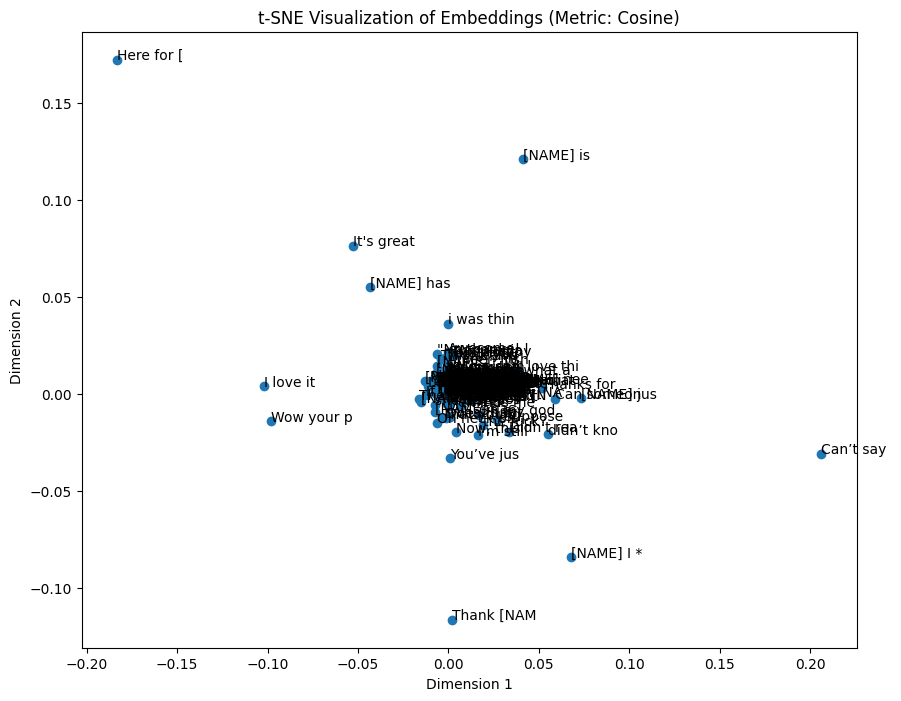

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


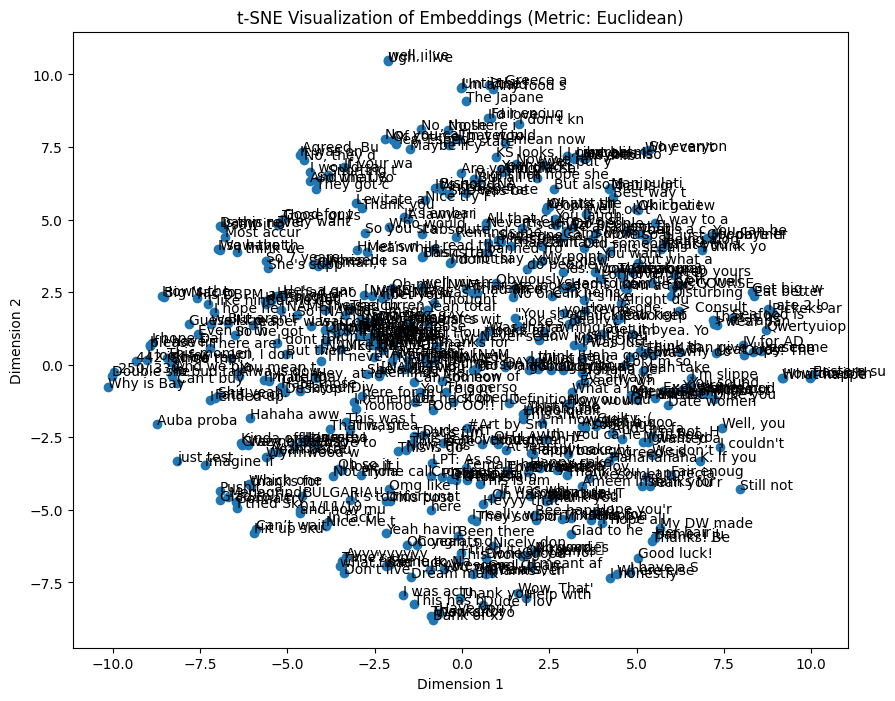

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


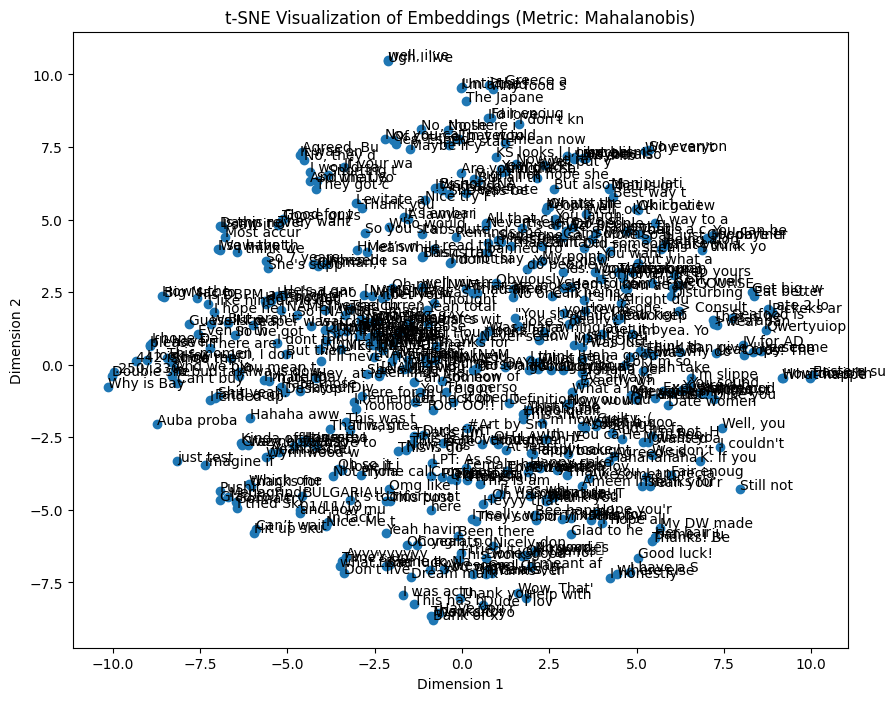

In [52]:
# 8. Metrics visualizationg
visualize_embeddings(embeddings, [t[:10] for t in texts], metric_name="Cosine", perplexity=15, n_iter=250)
visualize_embeddings(embeddings, [t[:10] for t in texts], metric_name="Euclidean")
visualize_embeddings(embeddings, [t[:10] for t in texts], metric_name="Mahalanobis")


Visualizing with Euclidean Distance:


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


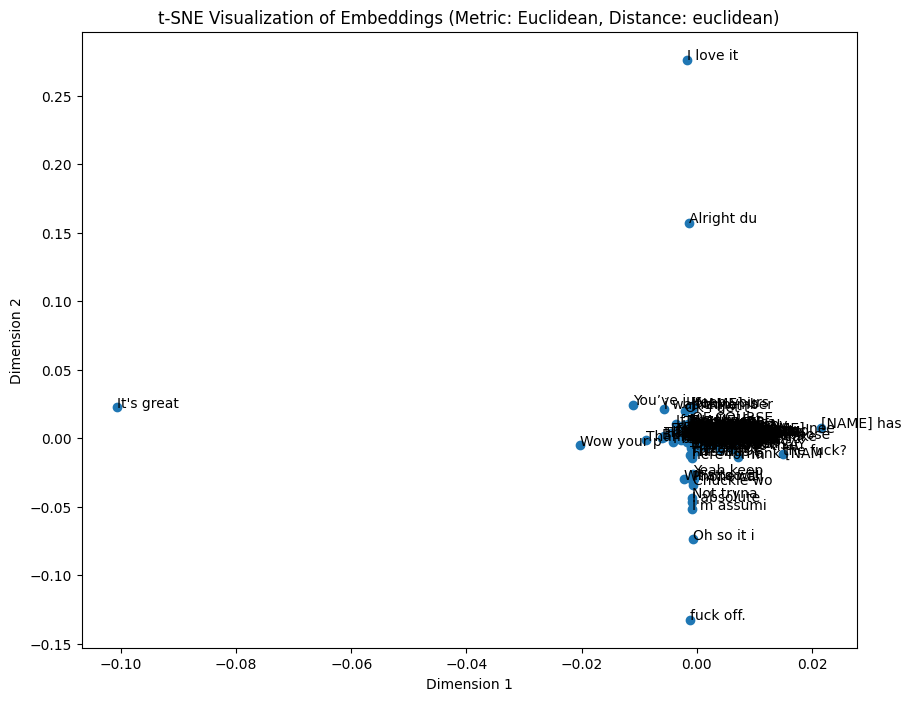

In [41]:
# 9: Distance test
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, labels, metric_name="default", distance_metric="euclidean", perplexity=30, n_iter=300):

    if distance_metric == "cosine":
        distance_matrix = pairwise_distances(embeddings, metric="cosine")
    elif distance_metric == "euclidean":
        distance_matrix = pairwise_distances(embeddings, metric="euclidean")
    else:
        raise ValueError("'euclidean'/'cosine'.")


    tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, metric="precomputed", n_iter=n_iter, init="random")
    embeddings_2d = tsne.fit_transform(distance_matrix)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title(f't-SNE Visualization of Embeddings (Metric: {metric_name}, Distance: {distance_metric})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()
print("\nVisualizing with Euclidean Distance:")
visualize_embeddings(embeddings, [t[:10] for t in texts], metric_name="Euclidean", distance_metric="euclidean", perplexity=15, n_iter=250)